# Sampling UNETv8
Script de prueba para ver el desempeño de UNETv8

In [47]:
import torch
from torch.utils.data import DataLoader
from guided_diffusion import *
from plotting_utils import *
from model3 import UNETv8
from tqdm import tqdm

In [55]:
BATCH_SIZE = 1
input_folder = r'C:\Users\u_imagenes\Documents\smerino\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\target_enh'
# input_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\input_id'
# output_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\target_enh'
data = CustomDataset(input_folder, output_folder, transform=True)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

In [39]:
# Define beta schedule
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)

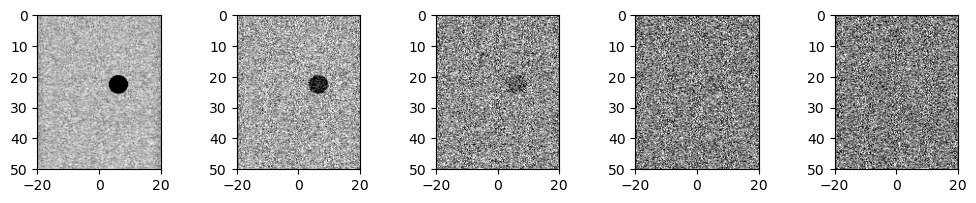

In [40]:
# Simulate forward diffusion
num_images = 5
stepsize = int(T/num_images)
plt.figure(figsize=(15,2))
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    noise = torch.randn_like(y_sample)
    img = forward_process(y_sample, t, gamma, noise)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    show_tensor_image(img.cpu())
plt.show()

Num params:  31232993


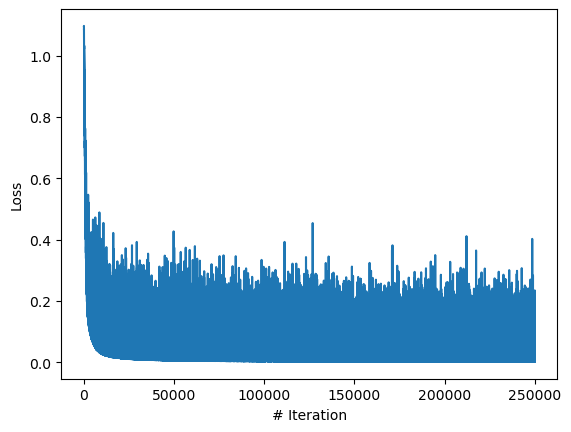

In [41]:
from model3 import UNETv8
from model4 import UNETv10
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v8_T1000'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.plot(loss_npy)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.show()

100%|██████████| 1000/1000 [00:16<00:00, 62.45it/s]


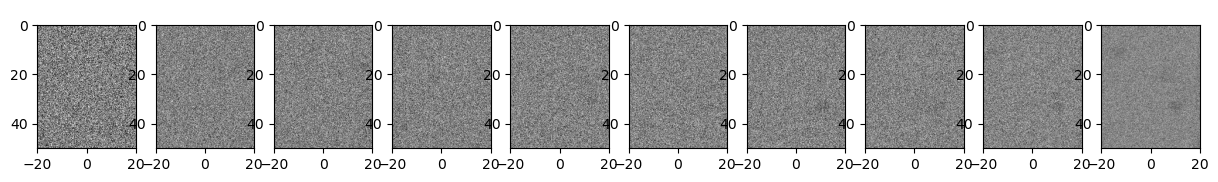

In [42]:
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta, num_intermediate=10)
show_reverse_process(intermediate_clamp)

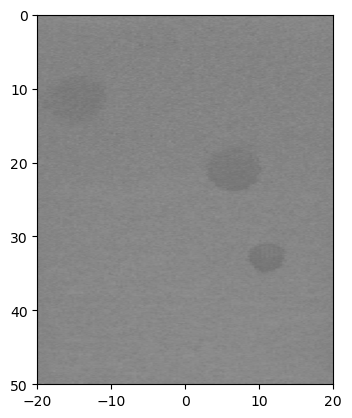

In [43]:
show_tensor_image(y_gen_clamp)
plt.show()

100%|██████████| 999/999 [00:15<00:00, 65.13it/s]


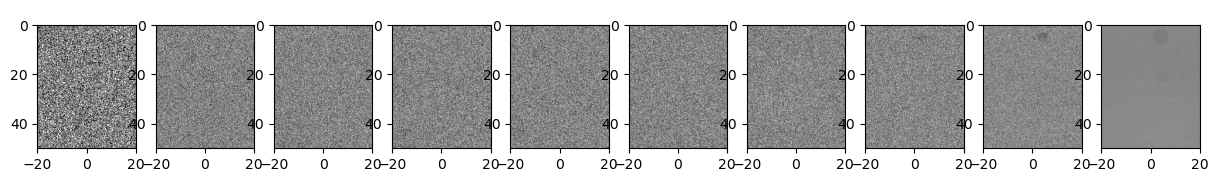

In [44]:
from diffusion_utils_v2 import sample_image_cond as sample2
y_gen_clamp, intermediate_clamp = sample2(x_sample, model, beta, num_intermediate=10)
show_reverse_process(intermediate_clamp)

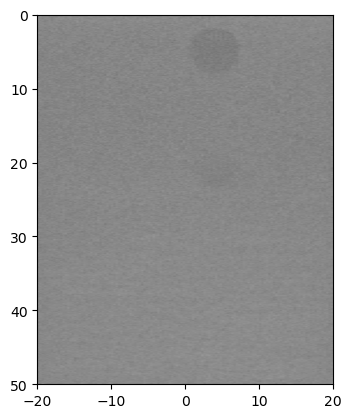

In [45]:
show_tensor_image(y_gen_clamp)
plt.show()

100%|██████████| 1000/1000 [00:15<00:00, 64.43it/s]


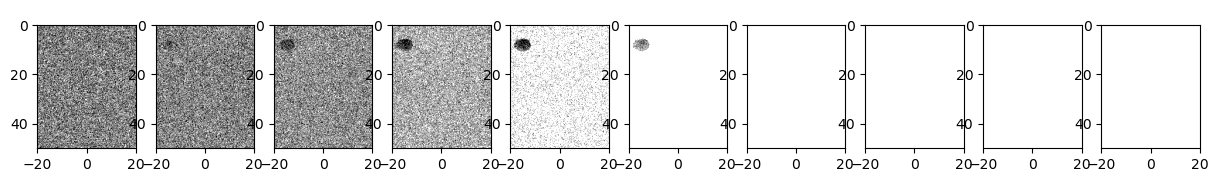

In [46]:
y_gen, intermediate = sample_image_cond(x_sample, model, beta, clamp=False, num_intermediate=10)
show_reverse_process(intermediate)

# Evaluating noise prediction

Setting new batch size

In [ ]:
BATCH_SIZE = 4
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

x_sample, y_sample = next(iter(dataloader))

In [ ]:
sample_timestep = 1
t = torch.Tensor([sample_timestep]).type(torch.int64).to(device)

noise = torch.randn_like(y_sample)
y_pert = forward_process(y_sample, t, gamma, noise)
input_model = torch.cat((x_sample.to(device), y_pert), 1)


plot_minibatch(y_pert, title="Diffused")
with torch.inference_mode():
    eps = model(input_model, t)
    predicted_noise = eps.detach().to('cpu').numpy().flatten()
    original_noise = noise.detach().to('cpu').numpy().flatten()

plot_minibatch(eps, title="Pred. noise")
plot_minibatch(eps - noise, title="Difference")
plt.figure(figsize=(12, 2))
plt.subplot(121)
plt.hist(predicted_noise, 100)
plt.title("Predicted noise")

plt.subplot(122)
plt.hist(original_noise, 100)
plt.title("Original noise")
plt.show()

print(f"Predicted mean: {np.mean(predicted_noise)}, std: {np.std(predicted_noise)}")
print(f"Original mean: {np.mean(original_noise)}, std: {np.std(original_noise)}")
print(f"MSE: {np.std(original_noise - predicted_noise) ** 2}")
plt.figure(figsize=(6, 2))
plt.hist(original_noise - predicted_noise, 100)
plt.title("Difference")
plt.show()

# Short schedule

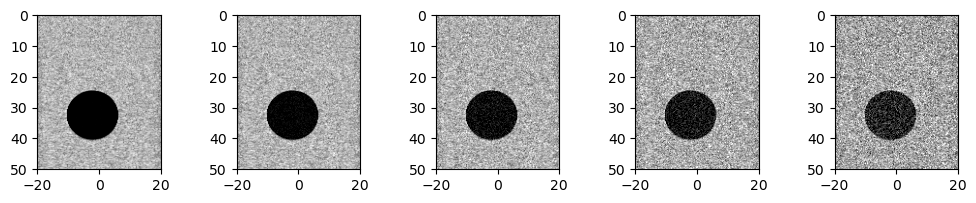

In [67]:
x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

# Define beta schedule
T = 100
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=2e-2, device=device)
# Simulate forward diffusion
num_images = 5
stepsize = int(T / num_images)
plt.figure(figsize=(15, 2))
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    noise = torch.randn_like(y_sample)
    img = forward_process(y_sample, t, gamma, noise)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    show_tensor_image(img.cpu())
plt.show()

Num params:  32531617


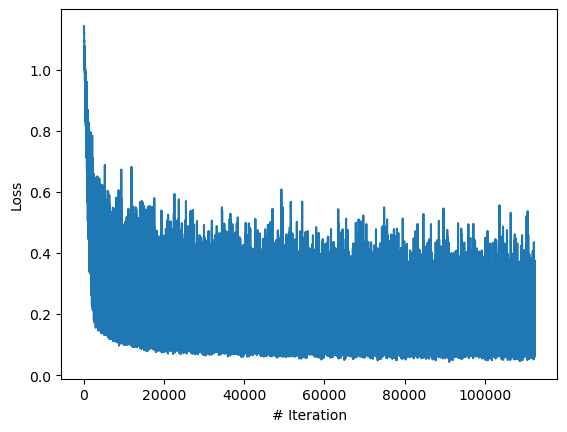

In [68]:
from model3 import UNETv8
# from model4 import UNETv10

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v8_T100'
training_epochs = 90
model = UNETv8(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.plot(loss_npy)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.show()

100%|██████████| 100/100 [00:05<00:00, 19.01it/s]


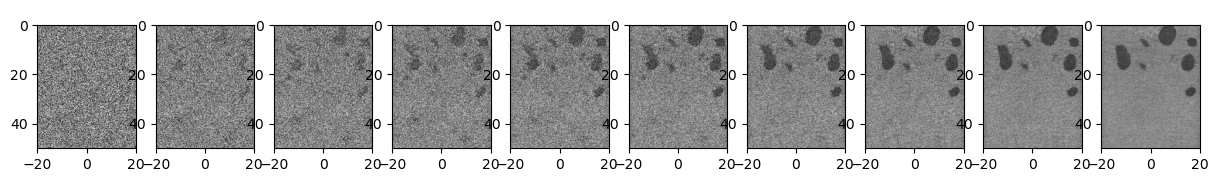

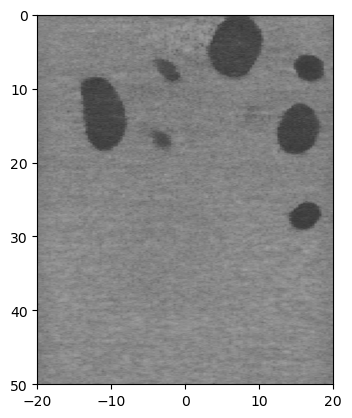

In [71]:
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta, num_intermediate=10)
show_reverse_process(intermediate_clamp)
show_tensor_image(y_gen_clamp)
plt.show()

100%|██████████| 100/100 [00:05<00:00, 19.73it/s]


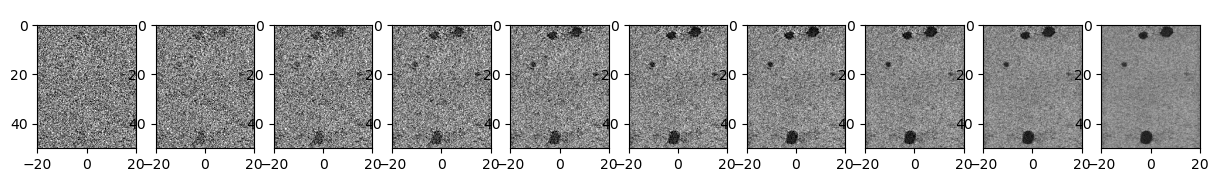

In [72]:
y_gen, intermediate = sample_image_cond(x_sample, model, beta, clamp=False, num_intermediate=10)
show_reverse_process(intermediate)

# Evaluating noise prediction
Setting new batch size

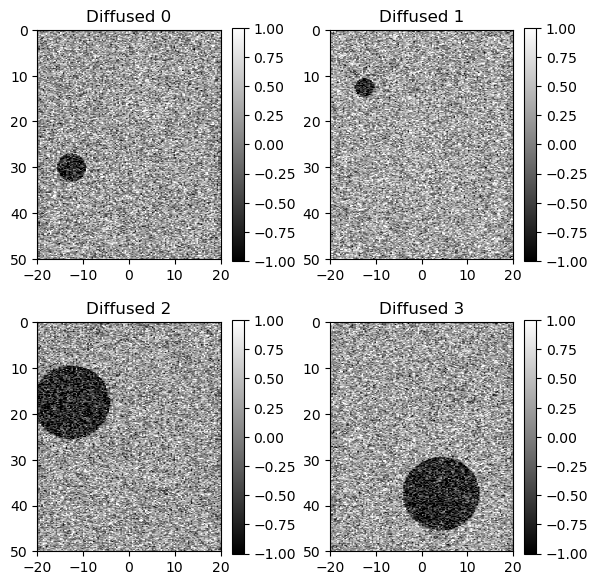

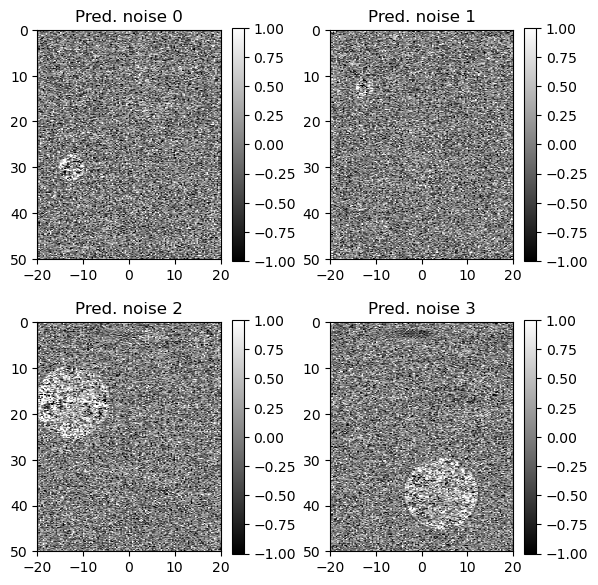

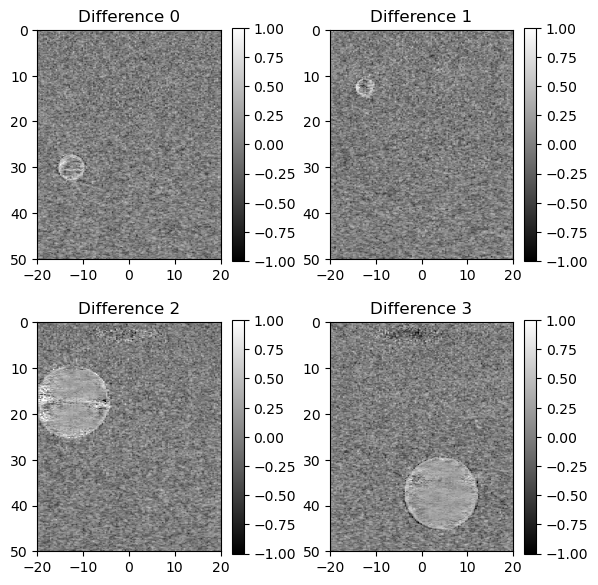

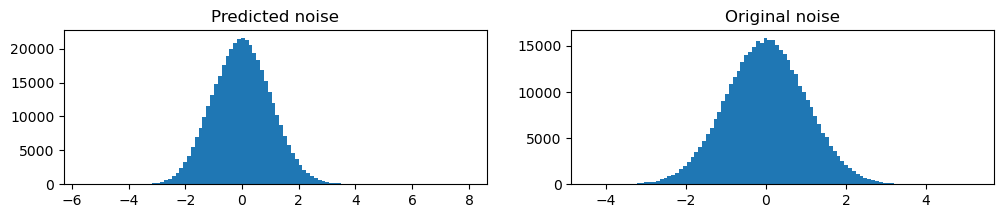

Predicted mean: -0.002434826921671629, std: 1.0272369384765625
Original mean: 0.0010850169928744435, std: 1.000817060470581
MSE: 0.0566729313647194


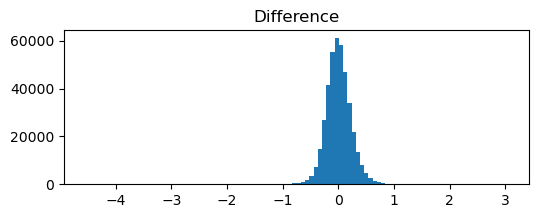

In [59]:
BATCH_SIZE = 4
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)
sample_timestep = 90
t = torch.Tensor([sample_timestep]).type(torch.int64).to(device)

noise = torch.randn_like(y_sample)
y_pert = forward_process(y_sample, t, gamma, noise)
input_model = torch.cat((x_sample.to(device), y_pert), 1)

plot_minibatch(y_pert, title="Diffused")
with torch.inference_mode():
    eps = model(input_model, t)
    predicted_noise = eps.detach().to('cpu').numpy().flatten()
    original_noise = noise.detach().to('cpu').numpy().flatten()

plot_minibatch(eps, title="Pred. noise")
plot_minibatch(eps - noise, title="Difference")
plt.figure(figsize=(12, 2))
plt.subplot(121)
plt.hist(predicted_noise, 100)
plt.title("Predicted noise")

plt.subplot(122)
plt.hist(original_noise, 100)
plt.title("Original noise")
plt.show()

print(f"Predicted mean: {np.mean(predicted_noise)}, std: {np.std(predicted_noise)}")
print(f"Original mean: {np.mean(original_noise)}, std: {np.std(original_noise)}")
print(f"MSE: {np.std(original_noise - predicted_noise) ** 2}")
plt.figure(figsize=(6, 2))
plt.hist(original_noise - predicted_noise, 100)
plt.title("Difference")
plt.show()